In [20]:
#Import Packages for SVM implementations
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [3]:
#Loading in the necessary packages
file_path = r"C:\Users\strou\Desktop\Machine Learning\Project 1\Data\project_adult.csv"
file_path_valid  = r"C:\Users\strou\Desktop\Machine Learning\Project 1\Data\project_validation_inputs.csv"

df = pd.read_csv(file_path, na_values='?')
df_valid = pd.read_csv(file_path_valid, na_values='?')

In [4]:
#Define a Function to Preprocess the Data
def preprocess_data(df):

  #Change income to a binary variable
  if 'income' in df.columns:
    df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

  #Get rid of education because it's the same as education num but not ordinal

  #drop na
  df = df.dropna()

  # Select categorical columns (object or category types)
  categorical_cols = df.select_dtypes(include=['object', 'category']).columns

  # Initialize encoder
  le = LabelEncoder()

  # Apply LabelEncoder to each categorical column in place
  for col in categorical_cols:
      df[col] = le.fit_transform(df[col])

  return df

In [5]:
#Actually preprocess data
df = preprocess_data(df)
df_valid = preprocess_data(df_valid)

C:\Users\strou\AppData\Local\Temp\ipykernel_51560\2056822723.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\strou\AppData\Local\Temp\ipykernel_51560\2056822723.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\strou\AppData\Local\Temp\ipykernel_51560\2056822723.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [6]:
# split data into training and test datasets
train = df.drop('income', axis=1) # Features are all columns except 'Unnamed: 0' and 'income'
X = train
y = df['income'] # Target is the 'income' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now X_train_scaled and X_test_scaled can be used for training and testing models
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [8]:
#Confustion Matrix Function
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))

    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

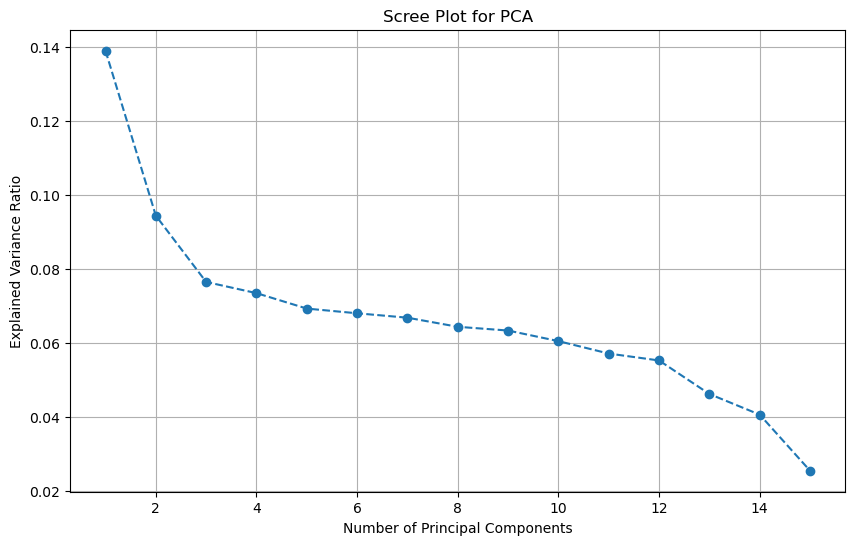

In [9]:
# Perform PCA without assuming a fixed number of components
# By default, PCA will compute all n_features components.
pca = PCA()
pca.fit(X_train_scaled) # this is on x train to compare performance

plt.figure(figsize=(10, 6))
explained_variance_ratio = pca.explained_variance_ratio_
components = range(1, len(explained_variance_ratio) + 1)
plt.plot(components, explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.grid(True)
plt.show()

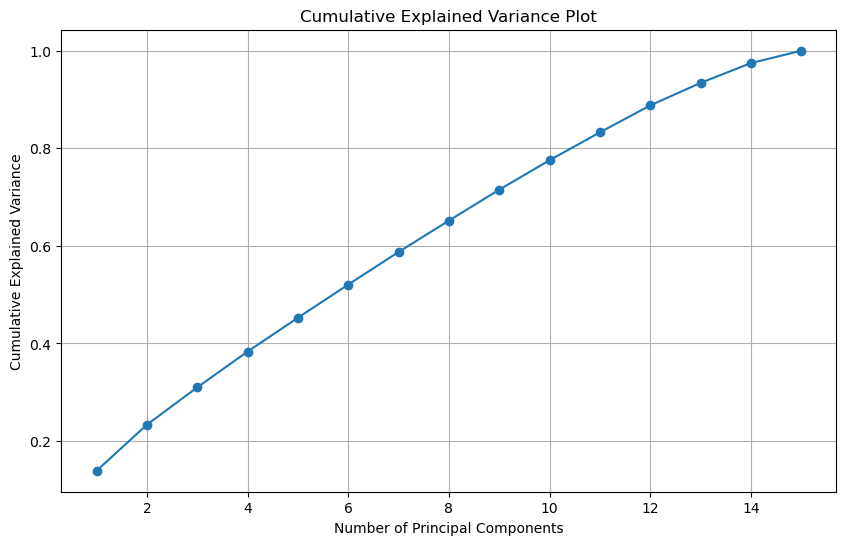

In [10]:
# reate the Cumulative Explained Variance Plot
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(components, cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)

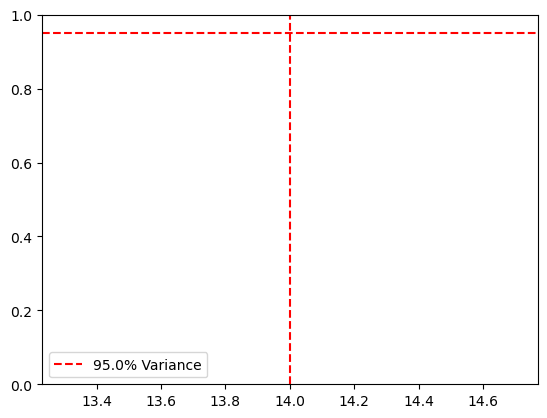

In [11]:
# Highlight a target variance, e.g., 95%
target_variance = 0.95
num_components_95 = np.argmax(cumulative_variance >= target_variance) + 1
plt.axvline(x=num_components_95, color='r', linestyle='--', label=f'{target_variance*100}% Variance')
plt.axhline(y=target_variance, color='r', linestyle='--')
plt.legend()
plt.show()

In [13]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train_scaled, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [14]:
# Make predictions on the scaled test set.
y_pred = grid_search.predict(X_test_scaled)


--- Confusion Matrix ---
[[3432  235]
 [ 540  625]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3667
           1       0.73      0.54      0.62      1165

    accuracy                           0.84      4832
   macro avg       0.80      0.74      0.76      4832
weighted avg       0.83      0.84      0.83      4832



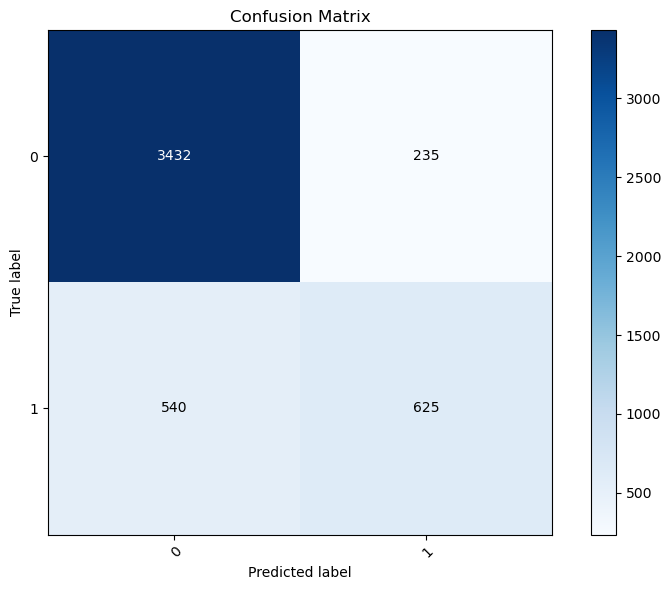

In [15]:
# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [16]:
# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best hyperparameters found:")
print(best_params)

Best hyperparameters found:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [17]:
#Generate predictions for the validation set based on the sk_y_pred_ada_ll results
df_valid = preprocess_data(df_valid)
df_valid_transform = scaler.transform(df_valid)
results = grid_search.predict(df_valid_transform)

# Use to_csv to save the results to a CSV file
pd.Series(results).to_csv('Group_1_SVM_PredictedOutputs.csv', index=False)

c:\Users\strou\miniconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [18]:
def plot_svm_decision_boundary(grid_search, X, y, feature_pair, scaler):
    """
    Plots a 2D slice of the decision boundary of a trained SVM from GridSearchCV.
    Other features are fixed at their mean values.

    Args:
        grid_search (GridSearchCV): Fitted GridSearchCV object
        X (pd.DataFrame): Original features (unscaled)
        y (pd.Series or np.ndarray): True labels
        feature_pair (tuple): Two column names to plot
        scaler (StandardScaler or similar): Fitted scaler used in training
    """
    f1, f2 = feature_pair
    model = grid_search.best_estimator_

    # Scale the full dataset using the original scaler
    X_scaled = scaler.transform(X)

    # Extract only the two features to plot
    f1_idx, f2_idx = X.columns.get_loc(f1), X.columns.get_loc(f2)
    X_plot = X_scaled[:, [f1_idx, f2_idx]]

    # Create meshgrid in the scaled feature space
    x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
    y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Prepare full feature array for prediction (all features fixed at mean)
    X_full = np.tile(X_scaled.mean(axis=0), (xx.ravel().shape[0], 1))
    X_full[:, f1_idx] = xx.ravel()
    X_full[:, f2_idx] = yy.ravel()

    # Predict using the trained model
    Z = model.predict(X_full)
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.figure(figsize=(8, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)

    # Plot actual points
    sns.scatterplot(x=X_plot[:, 0], y=X_plot[:, 1], hue=y, palette=['#FF0000', '#0000FF'],
                    alpha=0.6, edgecolor='k')

    plt.xlabel(f'{f1} (scaled)')
    plt.ylabel(f'{f2} (scaled)')
    plt.title(f"SVM Decision Boundary Slice ({f1} vs {f2})")
    plt.legend(title='Class')
    plt.show()



c:\Users\strou\miniconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


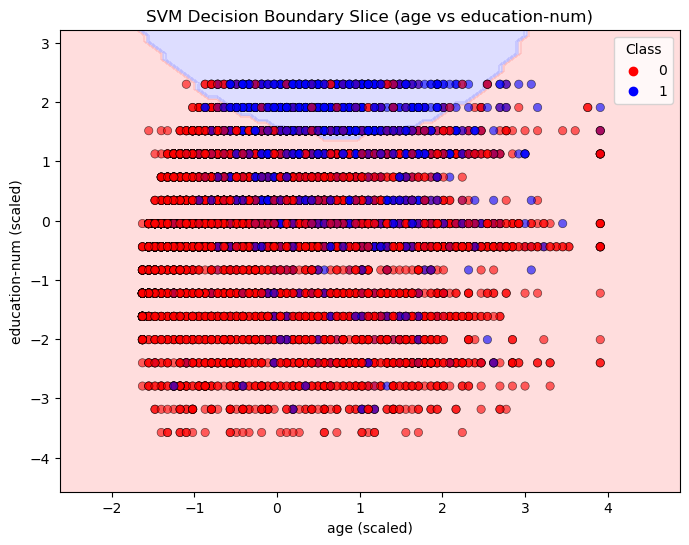

In [21]:
#Actually plot the boundary
plot_svm_decision_boundary(
    grid_search=grid_search,
    X=X_train,          # unscaled original DataFrame
    y=y_train,          
    feature_pair=('age', 'education-num'),
    scaler=scaler       # fitted StandardScaler from training
)


In [ ]:
#Compare C Values Across Multiple Values

# NOTE: Generating this chart takes a long time. It's supposed to produce the chart where SVM is regularized across multiple C values.
# The first run produced it successfully, but it was not re-generated for the repository.
# The chart can be reproduced by running this code locally. Apologies for the 

# The C values we tried
c_values = [0.01, 1.0, 100.0]

# Store metrics for each C
svm_metrics = []

for c in c_values:
    # Define param grid for this C
    param_grid = {
        'C': [c],
        'kernel': ['rbf', 'poly', 'gamma'],
        'gamma': ['auto']
    }
    grid_search = GridSearchCV(
        estimator=SVC(),
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )

    # Train
    grid_search.fit(X_train_scaled, y_train.values.ravel())

    # Predict
    y_pred = grid_search.predict(X_test_scaled)

    # Collect metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-score_0': report['0']['f1-score'],
        'F1-score_1': report['1']['f1-score']
    }
    svm_metrics.append(metrics)

# ---- Plotting Function ----
def plot_metrics_vs_c(c_values, metrics_data, model_name):
    """Plots evaluation metrics (Accuracy, F1-scores) vs. C values."""
    plt.figure(figsize=(12, 8))

    metrics = ['Accuracy', 'F1-score_0', 'F1-score_1']
    colors = ['blue', 'purple', 'orange']

    for i, metric in enumerate(metrics):
        plt.plot(c_values, [m[metric] for m in metrics_data],
                 marker='o', linestyle='-', color=colors[i], label=metric)

    plt.xscale('log')
    plt.xlabel('C (Regularization Strength)')
    plt.ylabel('Score')
    plt.title(f'{model_name} - Evaluation Metrics vs. C Value')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

# ---- Plot results ----
plot_metrics_vs_c(c_values, svm_metrics, "SVM")

# ---- Print results ----
print("\n--- F1-scores and Accuracy for SVM ---")
for i, c in enumerate(c_values):
    print(f"C = {c}:")
    print(f"  Accuracy: {svm_metrics[i]['Accuracy']:.4f}")
    print(f"  F1-score (Class 0): {svm_metrics[i]['F1-score_0']:.4f}")
    print(f"  F1-score (Class 1): {svm_metrics[i]['F1-score_1']:.4f}")

NameError: name 'GridSearchCV' is not defined